In [4]:
import cv2
import numpy as np

# 示例的 impurity_mask，假设在 CPU 上，已经扩大两倍
impurity_mask = np.array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                          [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                          [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0],
                          [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0],
                          [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0],
                          [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=np.uint8)

# 使用 OpenCV 的连通组件标记函数
num_labels, labeled_image = cv2.connectedComponents(impurity_mask, connectivity=4)

# 存储每个区域的位置、周长和中心位置
regions = []

# 遍历每个标记的区域
for label in range(1, num_labels):
    # 创建一个区域的掩码
    region_mask = (labeled_image == label).astype(np.uint8)

    # 计算区域的周长
    perimeter = cv2.arcLength(np.argwhere(region_mask == 1).astype(np.float32), closed=True)

    # 计算区域的重心
    moments = cv2.moments(region_mask)
    if moments["m00"] != 0:
        center_x = moments["m10"] / moments["m00"]
        center_y = moments["m01"] / moments["m00"]
        center = (center_x, center_y)

        # 将重心坐标四舍五入到最接近的整数坐标
        center = (round(center[0]), round(center[1]))

        # 检查中心是否在连通域内，如果不在内部，则将其移动到最接近的内部像素点
        if not region_mask[center[0], center[1]]:
            inside_pixels = np.argwhere(region_mask == 1)
            closest_pixel = inside_pixels[np.argmin(np.linalg.norm(inside_pixels - np.array(center).reshape(1, -1), axis=1))]
            center = (closest_pixel[0], closest_pixel[1])
    else:
        # 如果区域没有像素，将中心位置设置为 (-1, -1)
        center = (-1, -1)

    regions.append({
        "perimeter": perimeter,
        "center": center
    })

# 打印每个区域的周长和中心位置
for i, region in enumerate(regions):
    print(f"Region {i + 1}: Perimeter {region['perimeter']}, Center {region['center']}")


Region 1: Perimeter 59.94973564147949, Center (2, 2)
Region 2: Perimeter 13.300563097000122, Center (4, 6)
Region 3: Perimeter 6.0, Center (8, 3)


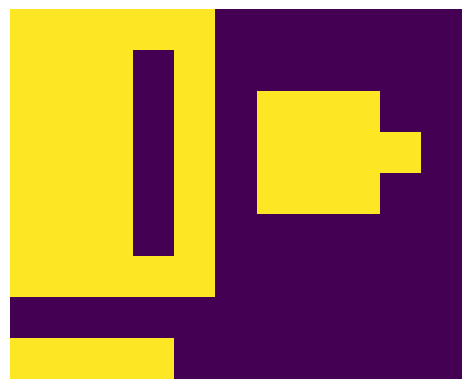

[[ 0  0 11  9 55]
 [ 0  0  5  7 30]
 [ 6  2  4  3 10]
 [ 0  8  4  1  4]]


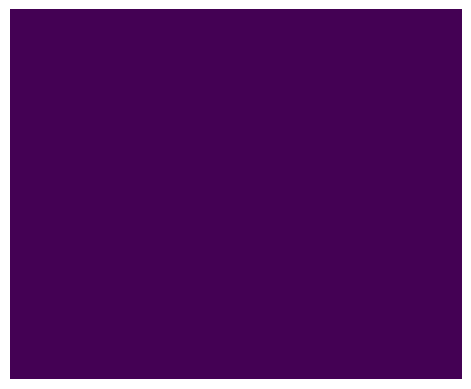

[(1, 3), (7, 3), (1, 8)]

In [135]:
impurity_mask = np.array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                          [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                          [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0],
                          [1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0],
                          [1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0],
                          [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
                          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=np.uint8)
plt.imshow(impurity_mask)
plt.axis('off')
plt.show()
calculate_center(impurity_mask)

In [134]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

def calculate_center(gray_img):
    """
    读取一张0、1二值灰度图，提出周长小的连通域，返回剩余连通域的中心点
    """
    # 读取灰度图像
    # gray_img = cv2.imread(r'D:\mycodes\tools\pre_annotationV2\output_gray_image.png', cv2.IMREAD_GRAYSCALE)

    # 使用连通组件标记来标记和提取连通域
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(gray_img)
    print(stats)

    # 初始化变量来存储连通域的中心点坐标和最近的点坐标
    connected_components_centers = []
    closest_points = []

    # 遍历每个连通域，跳过背景（标签为0）
    for label in range(1, len(stats)):
        # 获取连通域的中心点
        cX, cY  = centroids[label]
        cX, cY  = int(cX), int(cY)

        # 获取当前连通域的像素坐标
        pixels_in_component = np.argwhere(labels == label)

        if labels[cY, cX]<=0:
            # 计算中心点到该连通域内所有点的距离
            distances = cdist(np.array([(cY, cX)]), pixels_in_component)

            # 找到离中心点最近的点
            min_distance_index = np.argmin(distances)
            closest_point = tuple(pixels_in_component[min_distance_index])
            closest_points.append(closest_point)
            (cY, cX) = closest_point
        connected_components_centers.append((cX, cY))

    # # 将连通域和中心点绘制到图像上
    labeled_image = gray_img

    for center_point in connected_components_centers:
        cv2.circle(labeled_image, center_point, 10, 4, -1)
    # 显示图像
    plt.imshow(labeled_image)
    plt.axis('off')
    plt.show()
    return connected_components_centers

In [124]:
import cv2
import numpy as np

# 读取灰度图像
image = cv2.imread(r'D:\mycodes\tools\pre_annotationV2\output_gray_image.png', cv2.IMREAD_GRAYSCALE)

# 阈值化图像，将像素值1设为255，以便进行连通域标记
_, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)

# 使用连通组件标记来标记和提取连通域
_, labels, _, _ = cv2.connectedComponentsWithStats(thresholded)

# 定义一个函数来计算连通域的周长
def calculate_contour_length(label_image, label):
    mask = (label_image == label).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_length = 0
    
    for contour in contours:
        contour_length += cv2.arcLength(contour, closed=True)
    
    return contour_length

# 假设要计算的连通域的标签值为 label
label_to_calculate = 1  # 请替换为您要计算的连通域的标签值

# 调用函数计算连通域的周长
contour_length = calculate_contour_length(labels, label_to_calculate)

print(f"连通域 {label_to_calculate} 的周长为 {contour_length}")


连通域 1 的周长为 623.0020868778229


In [137]:
import cv2
import numpy as np

# 读取灰度图像
image = cv2.imread(r'D:\mycodes\tools\pre_annotationV2\output_gray_image.png', cv2.IMREAD_GRAYSCALE)

# 阈值化图像，将像素值1设为255，以便进行连通域标记
_, thresholded = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)

# 使用连通组件标记来标记和提取连通域
_, labels, _, _ = cv2.connectedComponentsWithStats(thresholded)

# 假设要膨胀的连通域的标签值为 label
label_to_dilate = 1  # 请替换为您要膨胀的连通域的标签值

# 创建一个膨胀核（kernel）
kernel_size = 10  # 膨胀核的大小，可以根据需要调整
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# 创建一个与标签图像大小相同的空白图像
dilated_image = np.zeros_like(labels)

# 找到要膨胀的连通域的像素坐标
pixels_to_dilate = (labels == label_to_dilate)

# 使用膨胀操作将连通域膨胀
dilated_pixels = cv2.dilate(pixels_to_dilate.astype(np.uint8), kernel, iterations=1)

# 更新膨胀后的图像
dilated_image[dilated_pixels > 0] = label_to_dilate

# 显示膨胀后的结果图像
cv2.imshow('Dilated Image', dilated_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


error: Unknown C++ exception from OpenCV code